Mean Squared Error (MSE): 0.34001504875009325
R-squared (R2): 0.8400819793741989
Mean Absolute Error (MAE): 0.20379562854485778
Overall Metrics for RandomForestRegressor:
Accuracy: 0.9495
Precision (Overall): 0.9494
Recall (Overall): 0.9495
F1-Score (Overall): 0.9483


Metrics for Unoccupied:
Precision: 0.9517
Recall: 0.9878
F1-Score: 0.9694
Accuracy: 0.9878


Metrics for Low:
Precision: 0.9420
Recall: 0.8761
F1-Score: 0.9079
Accuracy: 0.8761


Metrics for Medium:
Precision: 0.9333
Recall: 0.7517
F1-Score: 0.8327
Accuracy: 0.7517


Metrics for High:
Precision: 1.0000
Recall: 0.7451
F1-Score: 0.8539
Accuracy: 0.7451




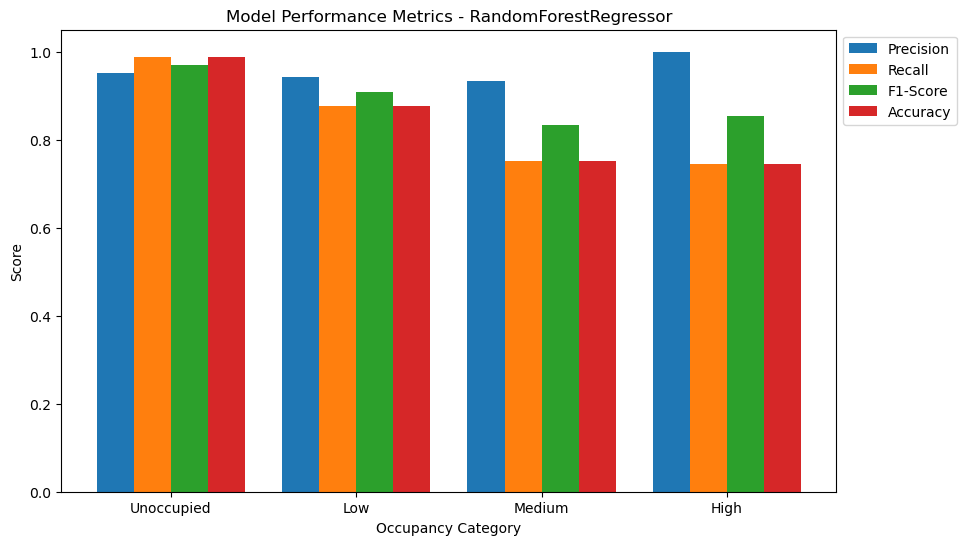

Classification Report for RandomForestRegressor:
              precision    recall  f1-score   support

  Unoccupied       1.00      0.75      0.85        51
         Low       0.94      0.88      0.91       872
      Medium       0.93      0.75      0.83       149
        High       0.95      0.99      0.97      2710

    accuracy                           0.95      3782
   macro avg       0.96      0.84      0.89      3782
weighted avg       0.95      0.95      0.95      3782



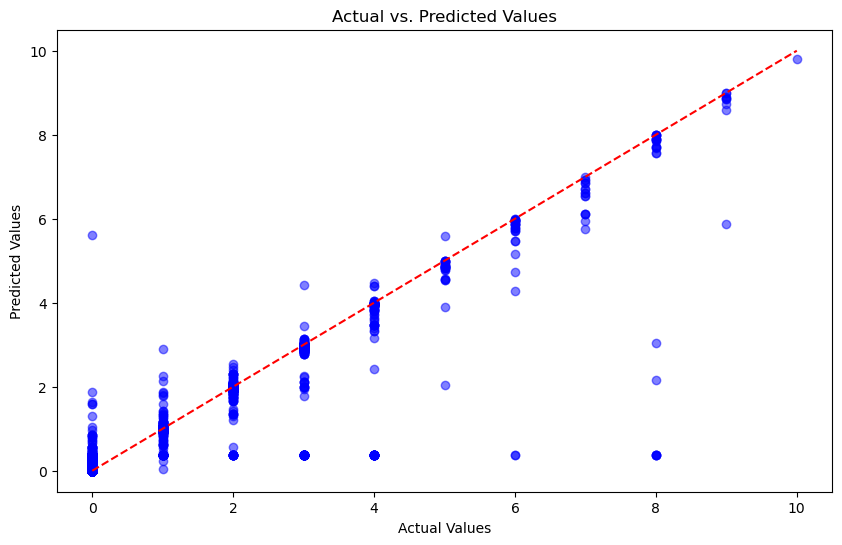

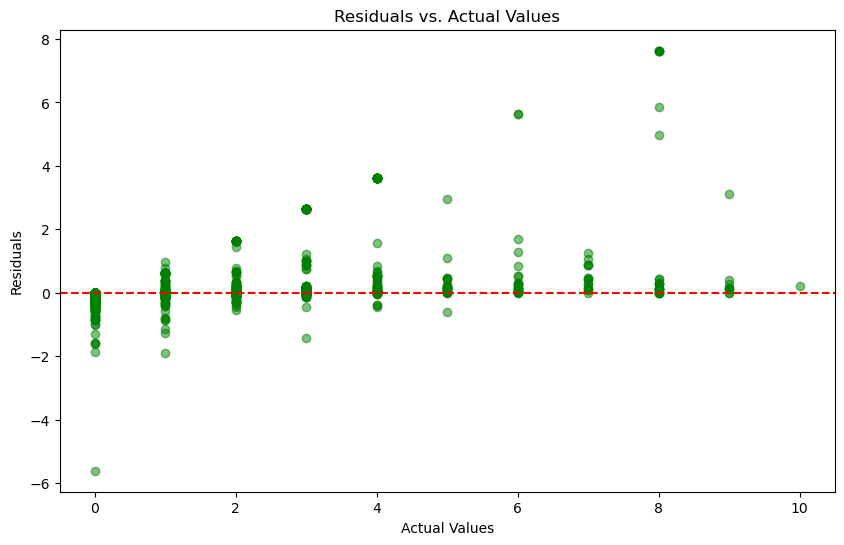

In [3]:
#Tampere Autoregression, using the output for classification.
#Classifying occupancy into Unoccupied, Low, Medium, High

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Load your data from 'data.csv'
df = pd.read_csv('Tampere/C0EA_edited_headings_final_tampere_28th_Nov_filtered_combined.csv', delimiter=",")

# Drop useless columns
drop_columns = ['MOVEMENT_ONBOARD_min', 'MOVEMENT_ONBOARD_max', 'MOVEMENT_ONBOARD_avg']
df = df.drop(columns=drop_columns)
# Convert 'Datetime' column to datetime format with dayfirst=True
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')

# Calculate the rate of change for the specified columns
rate_interest = ['VOC_ONBOARD_last', 'VOC_ONBOARD_min', 'VOC_ONBOARD_max', 'VOC_ONBOARD_avg',
                'CO2_SS_1_avg', 'CO2_SS_1_min', 'CO2_SS_1_max', 'CO2_SS_1_last',  'DBC_ONBOARD_max', 'DBC_ONBOARD_min', 'DBC_ONBOARD_avg', 'DBC_ONBOARD_last']
df[rate_interest] = df[rate_interest].replace(',', '.', regex=True).astype(float)

#Convert string columns to numeric
df['VOC_ONBOARD_max'] = pd.to_numeric(df['VOC_ONBOARD_max'], errors='coerce')
df['VOC_ONBOARD_min'] = pd.to_numeric(df['VOC_ONBOARD_min'], errors='coerce')
df['VOC_ONBOARD_last'] = pd.to_numeric(df['VOC_ONBOARD_last'], errors='coerce')

df['CO2_SS_1_max'] = pd.to_numeric(df['CO2_SS_1_max'], errors='coerce')
df['CO2_SS_1_min'] = pd.to_numeric(df['CO2_SS_1_min'], errors='coerce')
df['CO2_SS_1_last'] = pd.to_numeric(df['CO2_SS_1_last'], errors='coerce')
df['CO2_range'] = df['CO2_SS_1_max'] - df['CO2_SS_1_min']
df['VOC_range'] = df['VOC_ONBOARD_max'] - df['VOC_ONBOARD_min']

#Convert string columns to numeric
df['DBC_ONBOARD_max'] = pd.to_numeric(df['DBC_ONBOARD_max'], errors='coerce')
df['DBC_ONBOARD_min'] = pd.to_numeric(df['DBC_ONBOARD_min'], errors='coerce')
df['DBC_ONBOARD_last'] = pd.to_numeric(df['DBC_ONBOARD_last'], errors='coerce')
df['DBC_range'] = df['DBC_ONBOARD_max'] - df['DBC_ONBOARD_min']

auto_reg_sources = ['CO2_SS_1_last']  # Define the target columns for lagged features

# Define lag combinations
lag_combinations = [
    [5, 10, 15,20,25,30,35,40,45,50],
]

for lag_values in lag_combinations:  # Loop through different lag combinations
    for auto_reg_source in auto_reg_sources:
        for lag in lag_values:
            df[f'{auto_reg_source}_lag_{lag}'] = df[auto_reg_source].shift(lag)

    # Drop rows with NaN values after creating lagged features
    df.dropna(inplace=True)
    model_name = 'RandomForestRegressor'

    # Create a list of feature columns with lagged values
    lag_columns = [f'{auto_reg_source}_lag_{lag}' for auto_reg_source in auto_reg_sources for lag in lag_values]
    feature_columns = lag_columns #+ ['MOVEMENT_ONBOARD_last']  # Include the original column without lag

    # Replace commas (,) with periods (.) in feature columns and convert to float
    df[feature_columns] = df[feature_columns].replace(',', '.', regex=True).astype(float)

    # Specify the target column
    target_column = "CO2_SS_1_Inferred Occupancy" #'VOC_ONBOARD_Inferred Occupancy'#'VOC_ONBOARD_Inferred Occupancy' #"CO2_SS_1_Inferred Occupancy"

    # Split the data into features (X) and target (y)
    X = df[feature_columns]
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the model (Random Forest Regressor)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_test = y_pred.round().astype(int)
    y_pred_categories = pd.cut(y_pred_test, bins=[-np.inf, 0, 3, 6, np.inf], labels=['Unoccupied', 'Low', 'Medium', 'High'])
    y_test_categories = pd.cut(y_test, bins=[-np.inf, 0, 3, 6, np.inf], labels=['Unoccupied', 'Low', 'Medium', 'High'])
    class_names = y_test_categories.unique()

    # Calculate Mean Squared Error (MSE) and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)

    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    print("Mean Absolute Error (MAE):", mae)


    # Calculate overall metrics
    overall_accuracy = accuracy_score(y_test_categories, y_pred_categories)
    overall_precision = precision_score(y_test_categories, y_pred_categories, average='weighted')
    overall_recall = recall_score(y_test_categories, y_pred_categories, average='weighted')
    overall_f1 = f1_score(y_test_categories, y_pred_categories, average='weighted')

    # Print overall metrics
    print(f"Overall Metrics for {model_name}:")
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Precision (Overall): {overall_precision:.4f}")
    print(f"Recall (Overall): {overall_recall:.4f}")
    print(f"F1-Score (Overall): {overall_f1:.4f}")
    print("\n")

        # Calculate precision, recall, and f1-score for each class
    precision_values = precision_score(y_test_categories, y_pred_categories, average=None, labels=class_names)
    recall_values = recall_score(y_test_categories, y_pred_categories, average=None, labels=class_names)
    f1_values = f1_score(y_test_categories, y_pred_categories, average=None, labels=class_names)

    # Calculate accuracy for each class
    accuracy_values = [accuracy_score(y_test_categories[y_test_categories == class_name], y_pred_categories[y_test_categories == class_name]) for class_name in class_names]
    # Print metrics for each class
    for class_name, precision, recall, f1, accuracy in zip(class_names, precision_values, recall_values, f1_values, accuracy_values):
        print(f"Metrics for {class_name}:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print("\n")

    # Plot bar chart
    class_order = ['Unoccupied', 'Low','Medium' ,'High']
    index = np.arange(len(class_order))
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(class_order))

    # Function to get index for a label in the original class_names
    def get_index(label):
        return class_names.tolist().index(label)

    plt.bar(index, [precision_values[get_index(label)] for label in class_order], bar_width, label='Precision')
    plt.bar(index + bar_width, [recall_values[get_index(label)] for label in class_order], bar_width, label='Recall')
    plt.bar(index + 2 * bar_width, [f1_values[get_index(label)] for label in class_order], bar_width, label='F1-Score')
    plt.bar(index + 3 * bar_width, [accuracy_values[get_index(label)] for label in class_order], bar_width, label='Accuracy')

    plt.xlabel('Occupancy Category')
    plt.ylabel('Score')
    plt.title(f'Model Performance Metrics - {model_name}')
    plt.xticks(index + 1.5 * bar_width, class_order)
    # Add the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig('figures/performance_tampere_multi_Class_CO2_PIR_last_range.png')
    plt.show()

    # Specify class labels for the confusion matrix
    class_labels = ['Unoccupied', 'Low', 'Medium', 'High']
    
    # Create a confusion matrix
    confusion = confusion_matrix(y_test_categories, y_pred_categories)

    # Calculate classification report
    class_report = classification_report(y_test_categories, y_pred_categories, target_names=class_labels, output_dict=True)

    # Print the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test_categories, y_pred_categories, target_names=class_labels))
                              
    # Plot predicted values vs. actual values vs. residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='b', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.savefig('figures/performance_Rf_auto_CO2_PIR_Tampere.png')
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, residuals, c='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Actual Values")
    plt.savefig('figures/residual_Rf_auto_CO2_PIR_Tampere.png')
    plt.show()

    from joblib import dump
    # Uncomment below to save the model
    #dump(model, 'RF_autoregressor_co2_last_co2_range_pir_Tampere.joblib')
